# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os
import random
from glob import glob
import shutil
from PIL import Image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def unzip_to_folder(zip_path):
    folder_name = os.path.splitext(os.path.basename(zip_path))[0]
    os.makedirs(folder_name, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder_name)
    print(f"Unzipped {zip_path} → {folder_name}/")
    return folder_name

In [ ]:
# unzip_to_folder("/content/drive/MyDrive/patches.zip")

# extract_dir = "/content/patches"

# Stage A: Data Preprocessing
Skipped stage A after run once.

In [ ]:
# Step 2. Define a function to sample 50% uniformly across labels
def sample_dataset(input_dir, output_dir, sample_fraction=0.5, seed=42):
    """
    Randomly samples a given fraction of images from each class (and tile)
    while preserving folder structure and avoiding overwriting.
    """
    random.seed(seed)
    os.makedirs(output_dir, exist_ok=True)

    total_selected = 0
    total_available = 0

    # Loop through each label (high, moderate, low)
    for label in os.listdir(input_dir):
        label_path = os.path.join(input_dir, label)
        if not os.path.isdir(label_path):
            continue

        # Create label folder in output
        out_label_dir = os.path.join(output_dir, label)
        os.makedirs(out_label_dir, exist_ok=True)

        # Loop through each tile folder under that label
        for tile in os.listdir(label_path):
            tile_path = os.path.join(label_path, tile)
            if not os.path.isdir(tile_path):
                continue

            # Find all image files inside tile
            image_paths = glob(os.path.join(tile_path, '*.*'))
            image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

            n_total = len(image_paths)
            n_sample = int(n_total * sample_fraction)
            sampled = random.sample(image_paths, n_sample)

            # Create matching tile folder in output
            out_tile_dir = os.path.join(out_label_dir, tile)
            os.makedirs(out_tile_dir, exist_ok=True)

            # Copy sampled images
            for src in sampled:
                dst = os.path.join(out_tile_dir, os.path.basename(src))
                shutil.copy(src, dst)

            total_selected += n_sample
            total_available += n_total

            print(f"{label}/{tile}: {n_sample}/{n_total} images selected")

    print(f"\nTotal sampled: {total_selected}/{total_available} "
          f"({(total_selected/total_available)*100:.1f}%)")



In [ ]:
input_dir = "/content/patches"
output_dir = "/content/patches_sampled_50"

sample_dataset(input_dir, output_dir, sample_fraction=0.5)


In [ ]:
# Function to zip a folder

def zip_folder(folder_path, output_path=None):
    """
    Compresses a folder (and all its contents) into a .zip file.

    Args:
        folder_path (str): Path to the folder you want to zip.
        output_path (str, optional): Path (without .zip extension) for the output file.
                                     Defaults to same directory as folder_path.
    Returns:
        str: Full path to the created .zip file.
    """
    if output_path is None:
        output_path = folder_path  # saves as folder_path.zip

    # Remove trailing slash if present
    output_path = output_path.rstrip('/')

    # Create the zip file
    shutil.make_archive(output_path, 'zip', folder_path)

    zip_file = f"{output_path}.zip"
    print(f"Zipped folder saved to: {zip_file}")
    print(f"Size: {os.path.getsize(zip_file) / (1024*1024):.2f} MB")
    return zip_file


In [ ]:
folder_to_zip = "/content/patches_sampled_50"
output_zip_path = "/content/patches_sampled_50"  # will create patches_sampled_50.zip

zip_file = zip_folder(folder_to_zip, output_zip_path)

# Stage B: Modelling

In [ ]:
unzip_to_folder("/content/drive/MyDrive/patches_sampled_50.zip")

extract_dir = "/content/patches_sampled_50"

Unzipped /content/drive/MyDrive/patches_sampled_50.zip → patches_sampled_50/


# Create training, validation, and test splits

In [ ]:
# Step 2. Create training, validation, and test splits
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# -----------------------------
# Parameters
# -----------------------------
data_dir = extract_dir           # path to your extracted patches
img_size = (256, 256)
batch_size = 64
seed = 42

# -----------------------------
# Create initial 80/20 split
# -----------------------------
train_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,   # 20% for val+test
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_test_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# -----------------------------
# Split the 20% into 10% val + 10% test
# -----------------------------
val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

print(f"Train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Val batches:   {tf.data.experimental.cardinality(val_ds)}")
print(f"Test batches:  {tf.data.experimental.cardinality(test_ds)}")


Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.
Train batches: 38
Val batches:   5
Test batches:  5


In [ ]:
# Step 3. Prepare the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# Normalization to rescales pixel intensity range (e.g., 0–255 → 0–1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

def preprocess(ds):
    return ds.map(lambda x, y: (normalization_layer(x), y)).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = preprocess(train_ds)
val_ds   = preprocess(val_ds)
test_ds  = preprocess(test_ds)

# Build a CNN model

In [ ]:
# Step 4. Build a CNN model
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=img_size + (3,)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Train the model

In [ ]:
# Step 5. Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 504ms/step - accuracy: 0.3465 - loss: 1.8806 - val_accuracy: 0.3857 - val_loss: 1.0878
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.3728 - loss: 1.0749 - val_accuracy: 0.4571 - val_loss: 1.0596
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.4664 - loss: 1.0330 - val_accuracy: 0.4536 - val_loss: 1.0122
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5192 - loss: 0.9847 - val_accuracy: 0.5036 - val_loss: 0.9641
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.6041 - loss: 0.8875 - val_accuracy: 0.6000 - val_loss: 0.8725
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.6061 - loss: 0.8701 - val_accuracy: 0.5071 - val_loss: 1.0139
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7021 - loss: 0.7087 - val_accuracy: 0.6321 - val_loss: 0.8891
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.7738 - loss: 0.5507 - val_accuracy: 0

# Plot

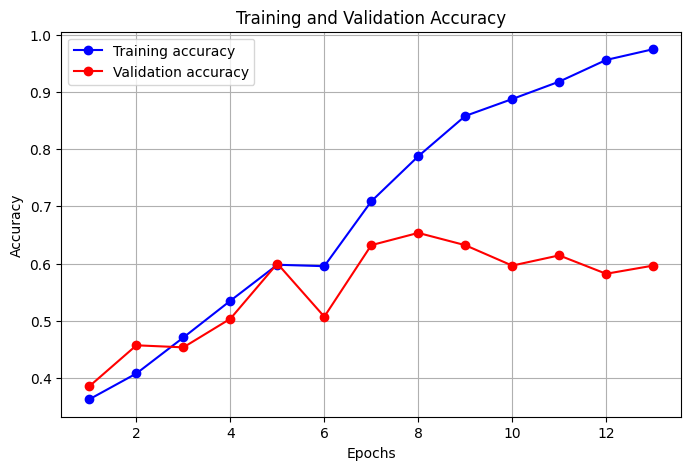

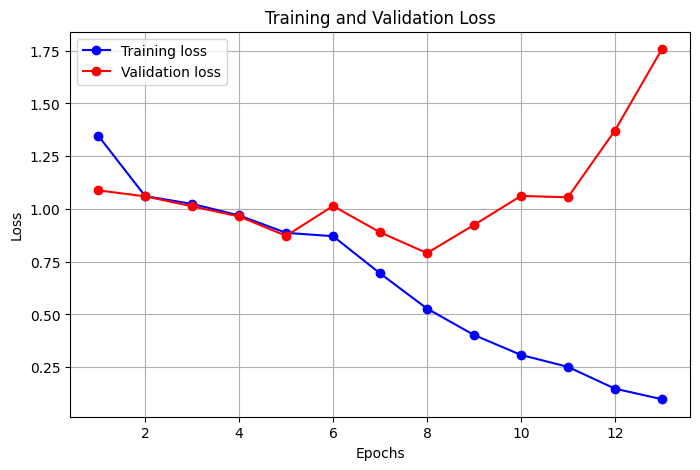

In [ ]:
import matplotlib.pyplot as plt

# Retrieve values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# -----------------------------
# Accuracy plot
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Loss plot
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Step 6. Evaluate and save model
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.2f}")

model.save("liquefaction_cnn.h5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6921 - loss: 0.8163


Test Accuracy: 0.70
